# Titanic: Machine Learning from Disaster
## Introduction
This is my first attempt at solving any kaggle.com challenge. It helped me quite a bit to be familiar with `pandas`, `sklearn`, `fancyimpute` and `seaborn`. So, let's get started.

At first import some useful modules.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from graphviz import Source
from IPython.display import display, Image, SVG

from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, scale, MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split

from sklearn import tree
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression

Using TensorFlow backend.


Read the data from csv files and show some info.

In [2]:
traindf = pd.read_csv("train.csv")
testdf = pd.read_csv("test.csv")
fulldf = [traindf, testdf]
print(traindf.info())
traindf.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
291,292,1,1,"Bishop, Mrs. Dickinson H (Helen Walton)",female,19.0,1,0,11967,91.0792,B49,C
593,594,0,3,"Bourke, Miss. Mary",female,NaN,0,2,364848,7.7500,NaN,Q
368,369,1,3,"Jermyn, Miss. Annie",female,NaN,0,0,14313,7.7500,NaN,Q
648,649,0,3,"Willey, Mr. Edward",male,NaN,0,0,S.O./P.P. 751,7.5500,NaN,S
84,85,1,2,"Ilett, Miss. Bertha",female,17.0,0,0,SO/C 14885,10.5000,NaN,S
584,585,0,3,"Paulner, Mr. Uscher",male,NaN,0,0,3411,8.7125,NaN,C
680,681,0,3,"Peters, Miss. Katie",female,NaN,0,0,330935,8.1375,NaN,Q
397,398,0,2,"McKane, Mr. Peter David",male,46.0,0,0,28403,26.0000,NaN,S
691,692,1,3,"Karun, Miss. Manca",female,4.0,0,1,349256,13.4167,NaN,C
371,372,0,3,"Wiklund, Mr. Jakob Alfred",male,18.0,1,0,3101267,6.4958,NaN,S


Now define some useful functions.

In [3]:
def survival_stat(df, colname):
    print(df[[colname, 'Survived']].groupby(colname).mean())

# encodes colname into df as onehot encoding, modifies df, 
# but does not delete colname
def onehot(df, colname):
    onehotdf = pd.get_dummies(df[colname])
    df[onehotdf.columns] = onehotdf[:]

def label_encode(df, colname):
    le = LabelEncoder()
    le.fit(df[colname])
    df[colname] = le.transform(df[colname])

# Measures accuracy score of a classifier over a dataset
def score(classifier, feature, target):
    return metrics.accuracy_score(classifier.predict(feature), target)

## Data Completion

In [4]:
print("Train data missing value statistics:")
print(traindf.isnull().sum())

print("\n")

print("Test data missing value statistics:")
print(testdf.isnull().sum())

Train data missing value statistics:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Test data missing value statistics:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


### Age
It has way too many missing entries in both datasets. For now, we'll leave it as it is and then impute the missing entries with a simple KNN based model.

### Age
It has way too many missing entries in both datasets. For now, we'll impute the missing entries with a simple KNN based model.

My previous attempt was fill in the missing values with random numbers from a uniformly random distribution. But, I feel like that model is kinda absurd since age is not actually a random variable. One can make a pretty accurate guess about a passenger's age from his/her title, passenger class, sex etc.

In [5]:
# for df in fulldf:
#     mean = df['Age'].mean()
#     std = df['Age'].std()
#     nullcount = df.isnull().sum()
#     def rand_age(x):
#         if np.isnan(x):
#             return np.random.randint(mean-std, mean+std)
#         else:
#             return x
#     df['Age'] = df['Age'].apply(rand_age)


In [6]:
simple_pred_cols = ['Pclass', 'Fare', 'Age', 'Sex']
for df in fulldf:
    tempdf = df[simple_pred_cols].copy()
    tempdf['Sex'] = df['Sex'].map({'male' : 0, 'female' : 1})
    tempdf[simple_pred_cols] = KNN(k=3).complete(tempdf[simple_pred_cols])
    df['Age'] = tempdf['Age']

Imputing row 1/891 with 0 missing, elapsed time: 0.231
Imputing row 101/891 with 0 missing, elapsed time: 0.233
Imputing row 201/891 with 0 missing, elapsed time: 0.235
Imputing row 301/891 with 1 missing, elapsed time: 0.236
Imputing row 401/891 with 0 missing, elapsed time: 0.238
Imputing row 501/891 with 0 missing, elapsed time: 0.239
Imputing row 601/891 with 0 missing, elapsed time: 0.242
Imputing row 701/891 with 0 missing, elapsed time: 0.244
Imputing row 801/891 with 0 missing, elapsed time: 0.245
Imputing row 1/418 with 0 missing, elapsed time: 0.032
Imputing row 101/418 with 0 missing, elapsed time: 0.033
Imputing row 201/418 with 1 missing, elapsed time: 0.034
Imputing row 301/418 with 0 missing, elapsed time: 0.035
Imputing row 401/418 with 0 missing, elapsed time: 0.037


### Embarked
Only training data has only two missing entries. So fill them with mode.

```
# for df in fulldf:
#     mean = df['Age'].mean()
#     std = df['Age'].std()
#     nullcount = df.isnull().sum()
#     def rand_age(x):
#         if np.isnan(x):
#             return np.random.randint(mean-std, mean+std)
#         else:
#             return x
#     df['Age'] = df['Age'].apply(rand_age)
```

In [7]:
for df in fulldf:
    mode = df['Embarked'].mode()[0]
    df['Embarked'].fillna(mode, inplace=True)

### Fare
Only one missing entry in test data. Also fill it with mode.

In [8]:
for df in fulldf:
    mode = df['Fare'].mode()[0]
    df['Fare'].fillna(mode, inplace=True)

For now, we won't care about `Cabin` as it has too many missing entries. However, it might be necessary later. 

**Now, recheck data for missing entries:**

In [9]:
print("Train data missing value statistics:")
print(traindf.isnull().sum())

print("\n")

print("Test data missing value statistics:")
print(testdf.isnull().sum())

Train data missing value statistics:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64


Test data missing value statistics:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


Let's save our data so far. Why? Because we'll examine `Age` once more.

In [10]:
fulldf_copy = [traindf.copy(), testdf.copy()]

## Feature Engineering 

### Sex


In [11]:
survival_stat(traindf, 'Sex')

        Survived
Sex             
female  0.742038
male    0.188908


(Captain Obvious!) Women were more likely to survive.

### Pclass

In [12]:
survival_stat(traindf, 'Pclass')

        Survived
Pclass          
1       0.629630
2       0.472826
3       0.242363


We'll map it the other way so that survivability increases with `Pclass`.

### Embarked

In [13]:
survival_stat(traindf, 'Embarked')

          Survived
Embarked          
C         0.553571
Q         0.389610
S         0.339009


### Parch and SibSp

In [14]:
survival_stat(traindf, 'Parch')
print("\n")
survival_stat(traindf, 'SibSp')

       Survived
Parch          
0      0.343658
1      0.550847
2      0.500000
3      0.600000
4      0.000000
5      0.200000
6      0.000000


       Survived
SibSp          
0      0.345395
1      0.535885
2      0.464286
3      0.250000
4      0.166667
5      0.000000
8      0.000000


Both stats look pretty similar. So it makes sense to combine these variables into one.Let's call this new column `FamilySize`.

In [15]:
for df in fulldf:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

We can make a decision tree to observe how `FamilySize`and `Sex` affects survivability.

In [16]:
def model_correlation(df, featurecol):
    targetcol = ['Survived']
    train = df[featurecol].copy()
    target = df[targetcol].copy()
    
    # Converts Categorical, ie, non numeric values to consecutive integers.
    for ftr in featurecol:
        if not np.issubdtype(train[ftr].dtype, np.number):
            print(train.head()[ftr])
            label_encode(train, ftr)
            # Take note which categories get which codes
            print(train.head()[ftr])
    
    dtree = tree.DecisionTreeClassifier(max_depth=3)
    dtree.fit(train, target)
    graph = Source( tree.export_graphviz(dtree, out_file=None, feature_names=featurecol, 
                                         filled=True, rounded=True, special_characters=True))
    display(Image(graph.pipe(format='png')))

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object
0    1
1    0
2    0
3    0
4    1
Name: Sex, dtype: int64


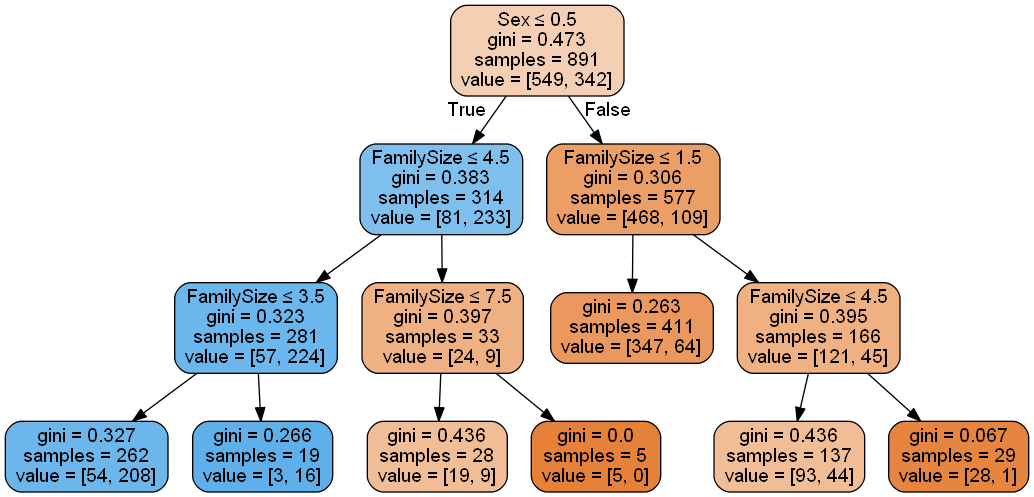

In [17]:
model_correlation(traindf, ['Sex', 'FamilySize'])

That means if you have a small family, you are more likely to survive.

### Age
`Age` is a continuous variable, so we need to cut it into some intervals. Before we actually do that, let's make a decision tree to see how `Age`, `Sex` and `Survived` are correlated.

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object
0    1
1    0
2    0
3    0
4    1
Name: Sex, dtype: int64


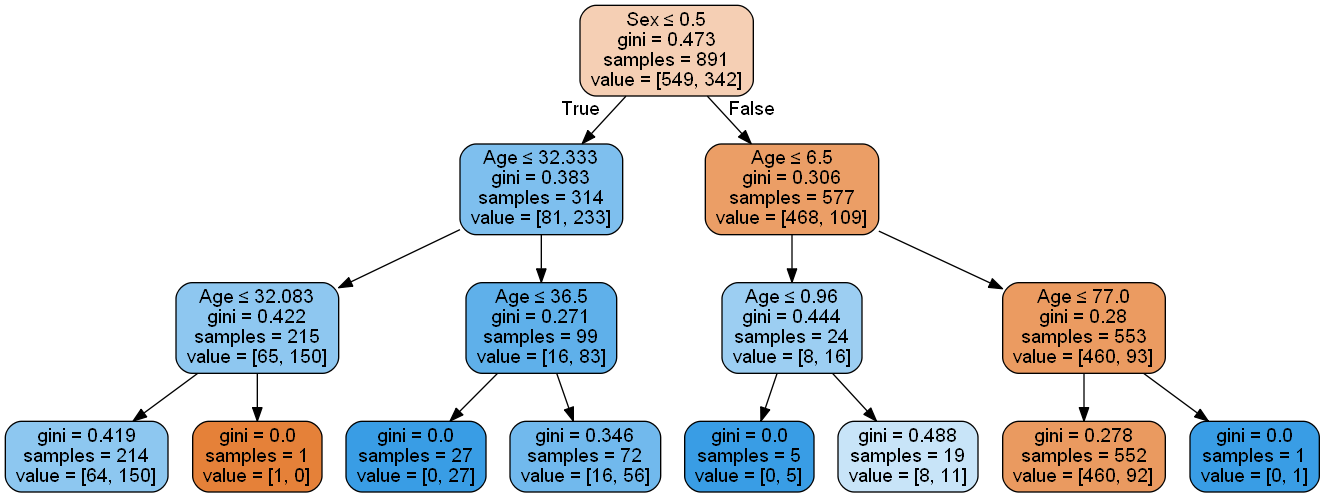

In [18]:
model_correlation(traindf, ['Sex', 'Age'])

As we can see, `Age` is more important for females than males.

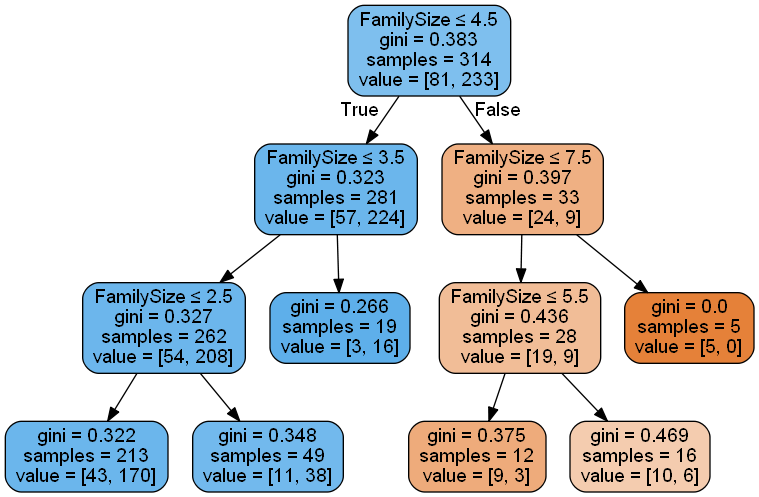

               Survived
AgeBucket              
(0.688, 13.2]  0.648649
(13.2, 25.65]  0.713043
(25.65, 38.1]  0.783505
(38.1, 50.55]  0.723404
(50.55, 63.0]  0.944444


In [19]:
womendf = traindf.loc[(traindf['Sex'] == 'female')].copy()
model_correlation(womendf, ['FamilySize'])
womendf['AgeBucket'] = pd.cut(womendf['Age'], 5)
survival_stat(womendf, 'AgeBucket')

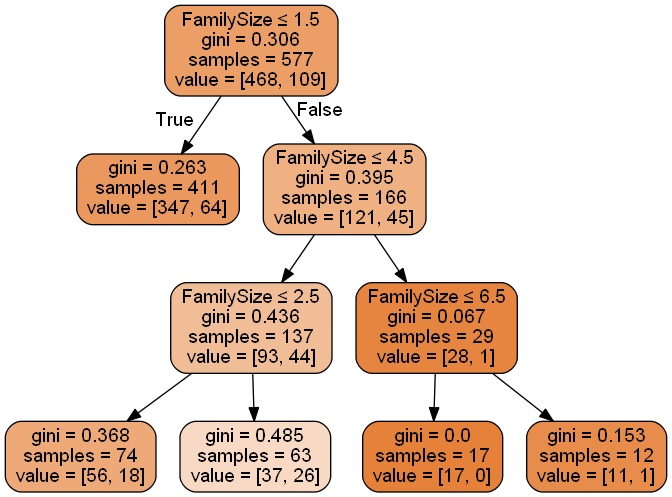

                  Survived
AgeBucket                 
(0.34, 13.683]    0.552632
(13.683, 26.947]  0.117021
(26.947, 40.21]   0.184211
(40.21, 53.473]   0.243902
(53.473, 66.737]  0.088235
(66.737, 80.0]    0.142857


In [20]:
mendf = traindf.loc[(traindf['Sex'] == 'male')].copy()
model_correlation(mendf, ['FamilySize'])
mendf['AgeBucket'] = pd.cut(mendf['Age'], 6)
survival_stat(mendf, 'AgeBucket')

So being a single man onboard is very bad. Also, female children survived somewhat less than other female groups. In contrast, male children survived more! We should encode that information.

In [21]:
for df in fulldf:
    df['AgeBucket'] = pd.cut(df['Age'], 6).cat.codes
    df['Child'] = np.where((df['Age'] < 15.0), 1.0, 0.0)
    df['SingleMale'] = np.where((df['FamilySize'] == 1.0 ) & (df['Sex'] == 'male'), 1.0, 0.0)
    

### Fare


In [22]:
traindf['FareBucket'] = pd.qcut(df['Fare'], 4)
survival_stat(traindf, 'FareBucket')

                   Survived
FareBucket                 
(-0.001, 7.896]    0.452174
(7.896, 14.454]    0.406250
(14.454, 31.472]   0.343137
(31.472, 512.329]  0.352381


In [23]:
for df in fulldf:
    df['FareBucket'] = pd.qcut(df['Fare'], 4)
    df['FareBucket'] = df['FareBucket'].cat.codes


### Name
Although the names themselves are unimportant, the titles are very important. Let's extract those.

In [24]:
Title_dict = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"
                }

for df in fulldf:
    df['Title'] = df['Name'].map(lambda name: name.split( ',' )[1].split( '.' )[0].strip())
    df['Title'] = df['Title'].map(Title_dict)
survival_stat(traindf, 'Title')

         Survived
Title            
Master   0.575000
Miss     0.701087
Mr       0.156673
Mrs      0.795276
Officer  0.277778
Royalty  0.600000


## Feature Encoding
### Sex

In [25]:
for df in fulldf:
    df["Sex"] = df["Sex"].map({"male" : 0, "female" : 2}).astype('int')

### Embarked
Label Encoder in the order Titanic visited them.

In [26]:
for df in fulldf:
    df["Embarked"] = df["Embarked"].map({'S': 1, 'Q' : 2, 'C' : 3}).astype('int')

### Title
Label encoding from least to most chance of survival.

In [27]:
for df in fulldf:
    df['Title'] = df['Title'].map({'Mr' : 0, 'Officer' : 1, 'Master' : 2, 'Royalty' : 3, 'Miss' : 4, 'Mrs' : 5}).astype('int')


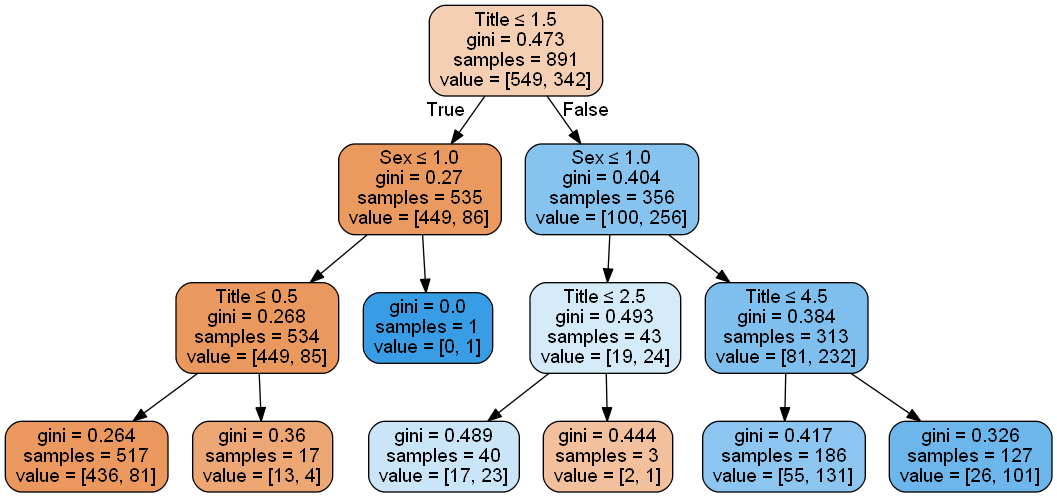

In [28]:
model_correlation(traindf, ['Title', 'Sex'])

Looks good. Time for data analysis.
## Data Analysis
The following plots show strong correlation among columns. I've commented them out, but you are encouraged to check them, especially heatmap.

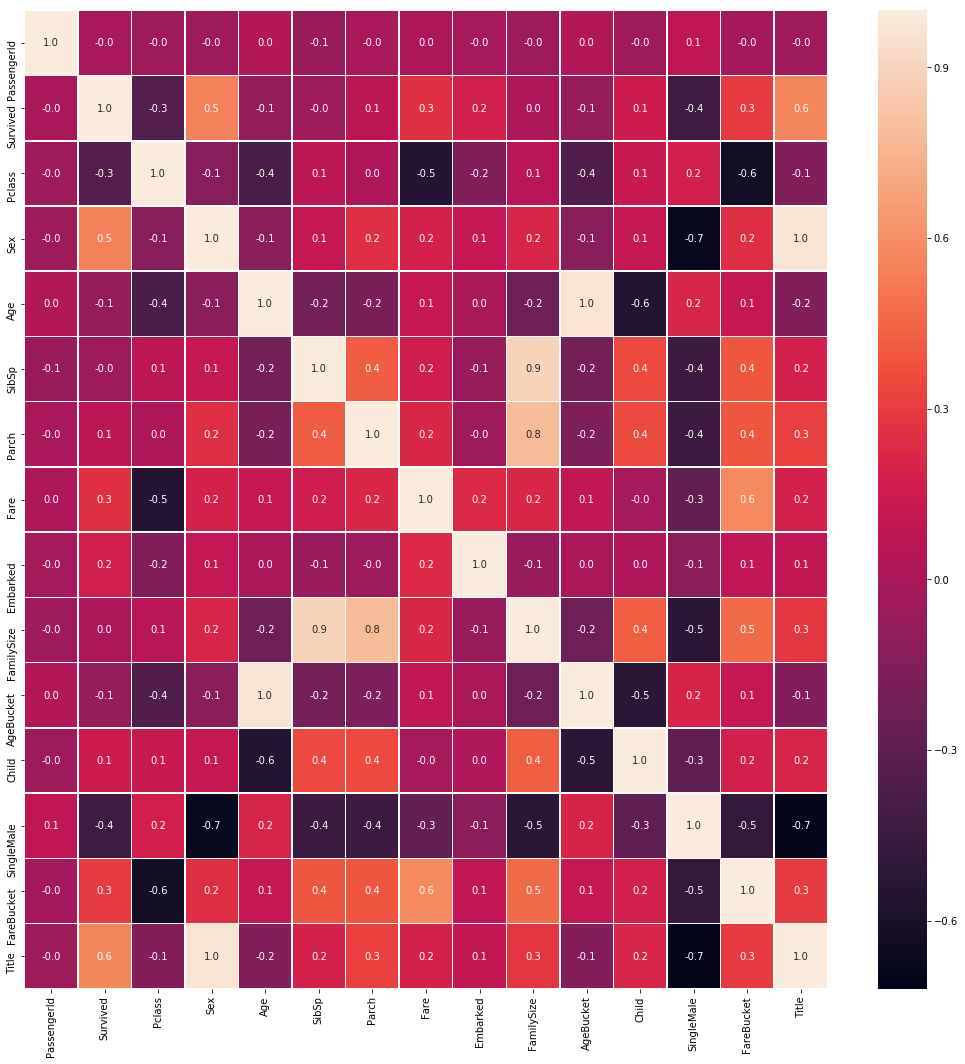

In [29]:
# plt.figure(figsize=(13,6))
# #fig, (ax1, ax2) = plt.subplots(1,2)
# sns.swarmplot(data=data_train, x="Pclass", y="Fare", hue="Survived")
# # sns.factorplot(x="Pclass", y="Fare", data=data_train, hue='Survived', kind="point")
# plt.show()


f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(traindf.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)


# sns.stripplot(x="Sex", y="Age", data=data_train, hue='Survived', jitter=True)
# plt.show()

# sns.distplot(data_train["Fare"])
# plt.show()

# feature_columns = ['Cherbourg', 'Southampton', 'Queenstown', 'Pclass', 'Sex', 'Age', 'Fare']
# target_column = ['Survived']

# train = data_train[feature_columns]
# target = data_train[target_column]

# from sklearn.tree import DecisionTreeClassifier
# from graphviz import Source
# from sklearn import tree

# dtree=DecisionTreeClassifier(criterion='entropy', max_depth=3, max_features=3)
# dtree.fit(train, target)

# from IPython.display import Image
# # from IPython.display import SVG
# graph = Source( tree.export_graphviz(dtree, out_file=None, feature_names=feature_columns, 
#                                      filled=True, rounded=True, special_characters=True))
# Image(graph.pipe(format='png'))


## Prediction
It is apparent that some features are more important than others. So we'll apply polynomial transformation to highlight those features.

In [30]:
traindf = traindf.sample(frac=1).reset_index(drop=True)
feature_columns = ['Sex', 'Title', 'FareBucket', 'Embarked', 'Pclass']
feature_columns2 = ['AgeBucket', 'FamilySize', 'SingleMale']
target_column = ['Survived']

pid_test = testdf['PassengerId'].copy()

finaltraindf = traindf[feature_columns].copy()
finaltestdf = testdf[feature_columns].copy()

fulldf = [finaltraindf, finaltestdf]

for df in fulldf:
    p = PolynomialFeatures(degree=2, interaction_only=True).fit(df)
    df[p.get_feature_names(df.columns)] = pd.DataFrame(p.transform(df))

finaltraindf[feature_columns2] = traindf[feature_columns2]
finaltestdf[feature_columns2] = testdf[feature_columns2]

## Finding best parameters
We'll `svc` as the classifier.

In [31]:
X = finaltraindf.copy()
y = traindf[target_column].as_matrix().ravel()

classifier = SVC()
C_range = np.logspace(-2, 3, 15)
gamma_range = np.logspace(-9, 2, 15)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2)
grid = GridSearchCV(classifier, param_grid=param_grid, cv=cv)
grid.fit(X, y)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 0.2682695795279726, 'gamma': 0.07196856730011514} with a score of 0.84


## Cross Validation

In [43]:
classifier = SVC(C=grid.best_estimator_.C, gamma=grid.best_estimator_.gamma)

testacc, trainacc = 0, 0
n = 50
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    classifier.fit(X_train, y_train)
    trainacc += score(classifier, X_train, y_train)
    testacc += score(classifier, X_test, y_test)
print('train accuracy:', trainacc/n)
print('test accuracy:', testacc/n)

train accuracy: 0.8494101123595512
test accuracy: 0.8222346368715082


## Writing to CSV

In [44]:
classifier.fit(X, y)
pred = classifier.predict(finaltraindf)
print("score:", metrics.accuracy_score(y, pred))

pred = classifier.predict(finaltestdf)
soldf = pd.DataFrame({'PassengerId' : pid_test, 'Survived' : pred})
soldf.to_csv("sol.csv", index=False)

score: 0.8451178451178452
